Link to Medium blog post: https://towardsdatascience.com/beyond-one-hot-17-ways-of-transforming-categorical-features-into-numeric-features-57f54f199ea4

In [82]:
!pip install category_encoders
import warnings
import hashlib
import numpy as np
import pandas as pd
import category_encoders as ce
import statsmodels.api as sm
import statsmodels.formula.api as smf

x = pd.Series(['2_Bachelors', '1_High-School', '4_PhD', '3_Masters', '1_High-School', '2_Bachelors'], name = 'x')


## Not All Encodings Are Created Equal

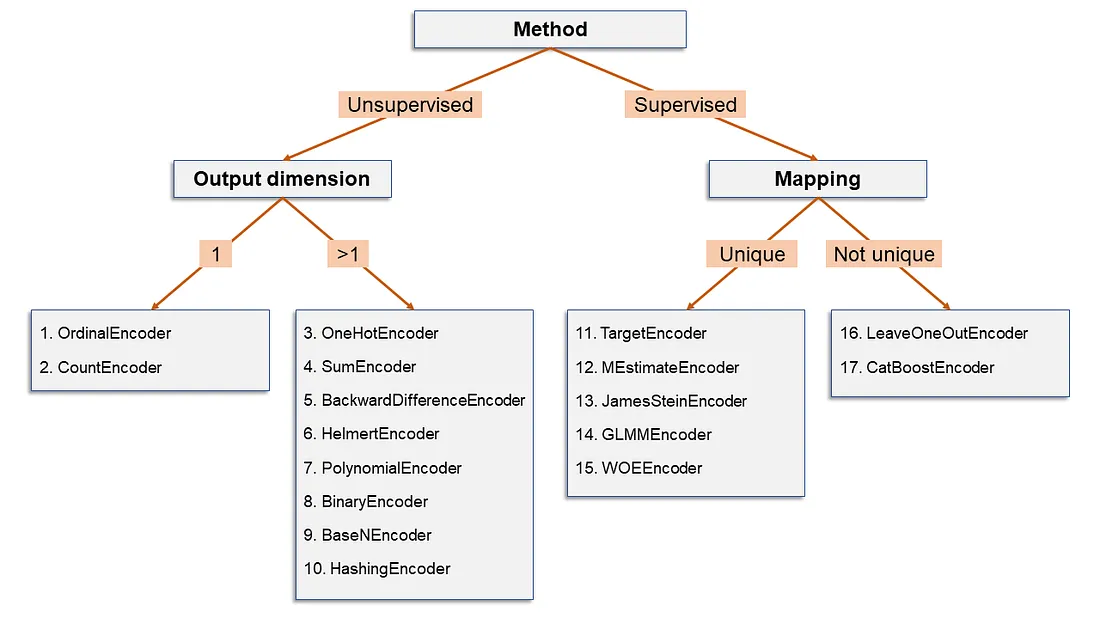

Here’s what the splits refer to:

- Supervised/Unsupervised: when the encoding is based solely on the categorical column, then it’s unsupervised. Otherwise, if the encoding is based on some function of the original column and a second (numeric) column, then it’s supervised.

- Output dimension: the encoding of a categorical column may produce one numeric column (output dimension = 1) or many numeric columns (output dimension > 1).

- Mapping: if each level has always the same output — whether a scalar (e.g. OrdinalEncoder) or an array (e.g. OneHotEncoder)— then the mapping is unique. On the contrary, if the same level is “allowed” to have different possible outputs, then the mapping is not unique.

## 1. OrdinalEncoder

Each level is mapped to an integer, from 1 to L (where L is the number of levels). In this case we have used alphabetical order, but any other custom order is acceptable.

In [48]:
sorted_x = sorted(set(x))
ordinal_encoding = x.replace(dict(zip(sorted_x, range(1, len(sorted_x) + 1))))

# ensure that our output coincides with the one from category_encoders
assert ordinal_encoding.eq(ce.OrdinalEncoder().fit_transform(X = x.sort_values())['x']).all()

# take  the first letter of each string and assign it to ordinal_ecoding
ordinal_encoding.name = 'OrdinalEncoding'
show = pd.concat([x, ordinal_encoding], axis = 1)
show

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/2319024793.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ordinal_encoding = x.replace(dict(zip(sorted_x, range(1, len(sorted_x) + 1))))


,x,OrdinalEncoding
0,2_Bachelors,2
1,1_High-School,1
2,4_PhD,4
3,3_Masters,3
4,1_High-School,1
5,2_Bachelors,2


You may think that ordinal encoding is non-sense, especially if the levels have no intrinsic order. You are right! In fact, it’s only a representation of convenience, used often to save memory, or as intermediate step for other types of encoding.

## 2. CountEncoder

Each level is mapped to the number of observations carrying that level.

In [51]:
x = pd.Series(['2_Bachelors', '1_High-School', '4_PhD', '3_Masters', '1_High-School', '2_Bachelors'], name = 'x')

In [54]:
count_encoding = x.replace(x.value_counts().to_dict())

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/159611061.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  count_encoding = x.replace(x.value_counts().to_dict())


In [55]:
count_encoding.name = 'CountEncoding'
show = pd.concat([x, count_encoding], axis = 1)
show

,x,CountEncoding
0,2_Bachelors,2
1,1_High-School,2
2,4_PhD,1
3,3_Masters,1
4,1_High-School,2
5,2_Bachelors,2


This encoding may be useful as an indicator of the “credibility” of each level. For instance, a machine learning algorithm may automatically decide to take into account the information brought by the level only its count is above some threshold.

## 3. OneHotEncoder


The encoding algorithm for excellence (and the most used). Each level is mapped to a dummy column (i.e. a column of 0/1), indicating whether that level is carried by that row.

In [56]:
x = pd.Series(['2_Bachelors', '1_High-School', '4_PhD', '3_Masters', '1_High-School', '2_Bachelors'], name = 'x')

In [57]:
ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))
one_hot_encoding = ordinal_encoding.apply(lambda e: pd.Series(np.diag(np.ones(len(set(x))))[e - 1].astype(int)))

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/1931251195.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))


In [58]:
import numpy as np

one_hot_encoding.columns = sorted(set(x))
show = pd.concat([x, ordinal_encoding, one_hot_encoding], axis = 1)
show.columns = [['x', 'OrdinalEncoding'] + ['OneHotEncoding'] * len(set(x)), [''] * 2 + list(one_hot_encoding.columns)]
show

x OrdinalEncoding OneHotEncoding                            
                                  1_High-School 2_Bachelors 3_Masters 4_PhD
0    2_Bachelors               2              0           1         0     0
1  1_High-School               1              1           0         0     0
2          4_PhD               4              0           0         0     1
3      3_Masters               3              0           0         1     0
4  1_High-School               1              1           0         0     0
5    2_Bachelors               2              0           1         0     0

In [83]:
x = pd.Series(['1_High-School', '2_Bachelors', '3_Masters', '4_PhD'], name = 'x')
x.index = x.to_list()
y = pd.Series([35, 45, 52, 68], index = x.index, name = 'y')

one_hot_encoding = ce.OneHotEncoder().fit_transform(X = x.sort_values()) #.rename(lambda c: int(c[2:]) - 1, axis='columns')
one_hot_encoding.columns = x.to_list()

ols_coefs = sm.OLS(y, pd.concat([pd.Series(1, index = x.index, name = 'intercept'), one_hot_encoding], axis = 1)).fit().params
ols_coefs.index = ['intercept'] + x.to_list()

show = pd.concat([x, one_hot_encoding, y, ols_coefs], axis = 1).loc[['intercept'] + x.to_list(), :]
show.index = ['intercept'] + x.to_list()
show.columns = [['x'] + ['OneHotEncoding'] * len(set(x)) + ['y', 'ols_coefs'], [''] + list(one_hot_encoding.columns) + [''] * 2]
show.fillna('')

x OneHotEncoding                                 y  \
                              1_High-School 2_Bachelors 3_Masters 4_PhD         
intercept                                                                       
1_High-School  1_High-School            1.0         0.0       0.0   0.0  35.0   
2_Bachelors      2_Bachelors            0.0         1.0       0.0   0.0  45.0   
3_Masters          3_Masters            0.0         0.0       1.0   0.0  52.0   
4_PhD                  4_PhD            0.0         0.0       0.0   1.0  68.0   

              ols_coefs  
                         
intercept          40.0  
1_High-School      -5.0  
2_Bachelors         5.0  
3_Masters          12.0  
4_PhD              28.0

## 4. SumEncoder

The code that follows may seem a little obscure at first. But don’t worry: in this case, it’s not so important to understand how the encoding is obtained, but how to use it.

In [60]:
x = pd.Series(['2_Bachelors', '1_High-School', '4_PhD', '3_Masters', '1_High-School', '2_Bachelors'], name = 'x')

In [61]:
ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))
one_hot_encoding = ordinal_encoding.apply(lambda e: pd.Series(np.diag(np.ones(len(set(x))))[e - 1].astype(int)))
sum_encoding = one_hot_encoding.iloc[:, :-1].apply(lambda row: row if row.sum() == 1 else row.replace(0, -1), axis = 1)

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/2050339368.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))


In [62]:
sum_encoding.columns = sorted(set(x))[:-1]
show = pd.concat([x, ordinal_encoding, sum_encoding], axis = 1)
show.columns = [['x', 'OrdinalEncoding'] + ['SumEncoding'] * (len(set(x)) - 1), [''] * 2 + sorted(set(x))[:-1]]
show

x OrdinalEncoding   SumEncoding                      
                                 1_High-School 2_Bachelors 3_Masters
0    2_Bachelors               2             0           1         0
1  1_High-School               1             1           0         0
2          4_PhD               4            -1          -1        -1
3      3_Masters               3             0           0         1
4  1_High-School               1             1           0         0
5    2_Bachelors               2             0           1         0

SumEncoder (as the next 3 encoders) belongs to a class called “contrast encodings”. These encodings are designed to have a specific behaviour when used in regression problems. In other words, you use one of these encodings if you want the regression coefficients to have some specific properties.

In [84]:
x = pd.Series(['1_High-School', '2_Bachelors', '3_Masters', '4_PhD'], name = 'x')
x.index = x.to_list()
y = pd.Series([35, 45, 52, 68], index = x.index, name = 'y')

sum_encoding = ce.SumEncoder().fit_transform(X = x.sort_values()).drop('intercept', axis = 1)
sum_encoding.columns = x.to_list()[:-1]

ols_coefs = sm.OLS(y, pd.concat([pd.Series(1, index = sum_encoding.index, name = 'intercept'), sum_encoding], axis = 1)).fit().params

show = pd.concat([x, sum_encoding, y, ols_coefs], axis = 1).loc[['intercept'] + x.to_list()]
show.columns = [['x'] + ['SumEncoding'] * sum_encoding.shape[1] + ['y', 'ols_coefs'], [''] + list(sum_encoding.columns) + [''] * 2]
show.fillna('')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


x   SumEncoding                           y  \
                             1_High-School 2_Bachelors 3_Masters         
intercept                                                                
1_High-School  1_High-School           1.0         0.0       0.0  35.0   
2_Bachelors      2_Bachelors           0.0         1.0       0.0  45.0   
3_Masters          3_Masters           0.0         0.0       1.0  52.0   
4_PhD                  4_PhD          -1.0        -1.0      -1.0  68.0   

              ols_coefs  
                         
intercept          50.0  
1_High-School     -15.0  
2_Bachelors        -5.0  
3_Masters           2.0  
4_PhD

##  5. BackwardDifferenceEncoder

This encoder is useful for ordinal variables, i.e. variables whose levels can be ordered in a meaningful way. BackwardDifferenceEncoder is designed to compare adjacent levels.

In [63]:
x = pd.Series(['2_Bachelors', '1_High-School', '4_PhD', '3_Masters', '1_High-School', '2_Bachelors'], name = 'x')

In [64]:
ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))
backward_difference_encoding = ordinal_encoding.apply(
    lambda oe: pd.Series(
        [i / len(set(x)) for i in range(1, oe)] + [- i / len(set(x)) for i in range(len(set(x)) - oe, 0, -1)]))


/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/810345154.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))


In [65]:
backward_difference_encoding.columns = sorted(set(x))[1:]
show = pd.concat([x, ordinal_encoding, backward_difference_encoding], axis = 1)
show.columns = [['x', 'OrdinalEncoding'] + ['BackwardDifferenceEncoding'] * len(sorted(set(x))[1:]), [''] * 2 + sorted(set(x))[1:]]
show

x OrdinalEncoding BackwardDifferenceEncoding                
                                                2_Bachelors 3_Masters 4_PhD
0    2_Bachelors               2                       0.25      -0.5 -0.25
1  1_High-School               1                      -0.75      -0.5 -0.25
2          4_PhD               4                       0.25       0.5  0.75
3      3_Masters               3                       0.25       0.5 -0.25
4  1_High-School               1                      -0.75      -0.5 -0.25
5    2_Bachelors               2                       0.25      -0.5 -0.25

Suppose you have an ordinable variable (e.g. education level) and you want to know how it is related to a numeric variable (e.g. income). It may be interesting to compare each couple of consecutive levels (e.g. bachelors vs. high-school, masters vs. bachelors) with respect to the target variable. This is what BackwardDifferenceEncoder is designed for.

In [85]:
x = pd.Series(['1_High-School', '2_Bachelors', '3_Masters', '4_PhD'], name = 'x')
x.index = x.to_list()
y = pd.Series([35, 45, 52, 68], index = x.index, name = 'y')

backward_difference_encoding = ce.BackwardDifferenceEncoder().fit_transform(X = x.sort_values()).drop('intercept', axis = 1)
backward_difference_encoding.columns = x.to_list()[1:]

ols_coefs = sm.OLS(y, pd.concat([pd.Series(1, index = backward_difference_encoding.index, name = 'intercept'), backward_difference_encoding], axis = 1)).fit().params

show = pd.concat([x, backward_difference_encoding, y, ols_coefs], axis = 1).loc[['intercept'] + x.to_list()]
show.columns = [['x'] + ['BackwardDifferenceEncoding'] * backward_difference_encoding.shape[1] + ['y', 'ols_coefs'], [''] + list(backward_difference_encoding.columns) + [''] * 2]
show.fillna('')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


x BackwardDifferenceEncoding                     y  \
                                            2_Bachelors 3_Masters 4_PhD         
intercept                                                                       
1_High-School  1_High-School                      -0.75      -0.5 -0.25  35.0   
2_Bachelors      2_Bachelors                       0.25      -0.5 -0.25  45.0   
3_Masters          3_Masters                       0.25       0.5 -0.25  52.0   
4_PhD                  4_PhD                       0.25       0.5  0.75  68.0   

              ols_coefs  
                         
intercept          50.0  
1_High-School            
2_Bachelors        10.0  
3_Masters           7.0  
4_PhD              16.0

##  6. HelmertEncoder

HelmertEncoder is very similar to BackwardDifferenceEncoder, but instead of being compared just to the previous one, each level is compared with all the previous levels.

In [66]:
x = pd.Series(['2_Bachelors', '1_High-School', '4_PhD', '3_Masters', '1_High-School', '2_Bachelors'], name = 'x')

In [67]:
# this implementation is similar to https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/
ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))
helmert_encoding = ordinal_encoding.apply(
    lambda oe: pd.Series([0] * (oe - 2) + ([oe - 1] if oe > 1 else []) + [-1] * (len(set(x)) - oe))
).div(pd.Series(range(2,len(set(x)) + 1)))


/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/270544200.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))


In [68]:
helmert_encoding.columns = sorted(set(x))[1:]
show = pd.concat([x, ordinal_encoding, helmert_encoding], axis = 1)
show.columns = [['x', 'OrdinalEncoding'] + ['HelmertEncoding'] * helmert_encoding.shape[1], [''] * 2 + sorted(set(x))[1:]]
show.round(2)

x OrdinalEncoding HelmertEncoding                
                                     2_Bachelors 3_Masters 4_PhD
0    2_Bachelors               2             0.5     -0.33 -0.25
1  1_High-School               1            -0.5     -0.33 -0.25
2          4_PhD               4             0.0      0.00  0.75
3      3_Masters               3             0.0      0.67 -0.25
4  1_High-School               1            -0.5     -0.33 -0.25
5    2_Bachelors               2             0.5     -0.33 -0.25

In [69]:
# in this case, the outcome of category_encoders has a different implementation
ce.HelmertEncoder().fit_transform(X = x.sort_values()).drop('intercept', axis = 1).rename(lambda c: int(c[2:]), axis='columns')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


,0,1,2
1,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0
0,1.0,-1.0,-1.0
5,1.0,-1.0,-1.0
3,0.0,2.0,-1.0
2,0.0,0.0,3.0


In [86]:
x = pd.Series(['1_High-School', '2_Bachelors', '3_Masters', '4_PhD'], name = 'x')
x.index = x.to_list()
y = pd.Series([35, 45, 52, 68], index = x.index, name = 'y')

ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))
helmert_encoding = ordinal_encoding.apply(
    lambda oe: pd.Series([0] * (oe - 2) + ([oe - 1] if oe > 1 else []) + [-1] * (len(set(x)) - oe))
).div(pd.Series(range(2,len(set(x)) + 1)))
helmert_encoding.columns = x.to_list()[1:]

ols_coefs = sm.OLS(y, pd.concat([pd.Series(1, index = helmert_encoding.index, name = 'intercept'), helmert_encoding], axis = 1)).fit().params

show = pd.concat([x, helmert_encoding, y, ols_coefs], axis = 1).loc[['intercept'] + x.to_list()]
show.columns = [['x'] + ['HelmertEncoding'] * helmert_encoding.shape[1] + ['y', 'ols_coefs'], [''] + list(helmert_encoding.columns) + [''] * 2]
show.fillna('')


/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/137618414.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))


x HelmertEncoding                     y ols_coefs
                                 2_Bachelors 3_Masters 4_PhD                
intercept                                                               50.0
1_High-School  1_High-School            -0.5 -0.333333 -0.25  35.0          
2_Bachelors      2_Bachelors             0.5 -0.333333 -0.25  45.0      10.0
3_Masters          3_Masters             0.0  0.666667 -0.25  52.0      12.0
4_PhD                  4_PhD             0.0       0.0  0.75  68.0      24.0

## 7. PolynomialEncoder


Another contrast encoding.

As its name suggests, PolynomialEncoder is designed to quantify linear, quadratic and cubic behaviors of the target variable with respect to the categorical variable.

In [71]:
x = pd.Series(['2_Bachelors', '1_High-School', '4_PhD', '3_Masters', '1_High-School', '2_Bachelors'], name = 'x')

In [72]:
def do_polynomial_encoding(order):
    # https://github.com/pydata/patsy/blob/master/patsy/contrasts.py
    n = len(set(x))
    scores = np.arange(n)
    scores = np.asarray(scores, dtype=float)
    scores -= scores.mean()
    raw_poly = scores.reshape((-1, 1)) ** np.arange(n).reshape((1, -1))
    q, r = np.linalg.qr(raw_poly)
    q *= np.sign(np.diag(r))
    q /= np.sqrt(np.sum(q ** 2, axis=1))
    # q[:, 0] = 1
    q = q[:, 1:]
    return q[order - 1]

ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))
polynomial_encoding = ordinal_encoding.apply(lambda oe: pd.Series(do_polynomial_encoding(oe)))

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/3343135483.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))


In [73]:
polynomial_encoding.columns = ['degree' + str(i) for i in range(1, polynomial_encoding.shape[1] + 1)]
show = pd.concat([x, ordinal_encoding, polynomial_encoding], axis = 1)
show.columns = [['x', 'OrdinalEncoding'] + ['PolynomialEncoding'] * polynomial_encoding.shape[1], 
                [''] * 2 + list(polynomial_encoding.columns)]
show.round(3)

x OrdinalEncoding PolynomialEncoding                
                                            degree1 degree2 degree3
0    2_Bachelors               2             -0.224    -0.5   0.671
1  1_High-School               1             -0.671     0.5  -0.224
2          4_PhD               4              0.671     0.5   0.224
3      3_Masters               3              0.224    -0.5  -0.671
4  1_High-School               1             -0.671     0.5  -0.224
5    2_Bachelors               2             -0.224    -0.5   0.671

How can a numeric variable have a linear (or quadratic, or cubic) relation with a variable that is not numeric? This is based on the assumption that the underlying categorical variable has levels that are not only ordinable, but also equally spaced.

For this reason, I would suggest to use it with care, only when you are sure that the assumption is reasonable.

In [87]:
x = pd.Series(['1_High-School', '2_Bachelors', '3_Masters', '4_PhD'], name = 'x')
x.index = x.to_list()
y = pd.Series([35, 45, 52, 68], index = x.index, name = 'y')

polynomial_encoding = ce.PolynomialEncoder().fit_transform(X = x.sort_values()).drop('intercept', axis = 1)
polynomial_encoding.columns = ['degree' + str(i) for i in range(1, polynomial_encoding.shape[1] + 1)]

ols_coefs = sm.OLS(y, pd.concat([pd.Series(1, index = polynomial_encoding.index, name = 'intercept'), polynomial_encoding], axis = 1)).fit().params

ols_coefs

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


intercept    50.000000
degree1      23.702321
degree2       3.000000
degree3       2.683282
dtype: float64

## 8. BinaryEncoder

BinaryEncoder is basically the same of OrdinalEncoder, the only difference is that the integers are converted to binary numbers, then every positional digit is one-hot encoded.

In [74]:
x = pd.Series(['2_Bachelors', '1_High-School', '4_PhD', '3_Masters', '1_High-School', '2_Bachelors'], name = 'x')

In [75]:
ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))
binary_base = ordinal_encoding.apply(lambda oe: str(bin(oe))[2:].zfill(len(bin(len(set(x)))) - 2))
binary_encoding = binary_base.apply(lambda bb: pd.Series(list(bb))).astype(int)

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/4032601258.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ordinal_encoding = x.replace(dict(zip(sorted(set(x)), range(1, len(sorted(set(x))) + 1))))


In [76]:
binary_encoding.columns = ['dim' + str(i) for i in range(binary_encoding.shape[1], 0, -1)]
show = pd.concat([x, ordinal_encoding, binary_base, binary_encoding], axis = 1)
show.columns = [
    ['x', 'OrdinalEncoding', 'binary_base'] + ['BinaryEncoding'] * binary_encoding.shape[1], 
    [''] * 3 + list(binary_encoding.columns)
]
show

x OrdinalEncoding binary_base BinaryEncoding          
                                                       dim3 dim2 dim1
0    2_Bachelors               2         010              0    1    0
1  1_High-School               1         001              0    0    1
2          4_PhD               4         100              1    0    0
3      3_Masters               3         011              0    1    1
4  1_High-School               1         001              0    0    1
5    2_Bachelors               2         010              0    1    0

The output consists of dummy columns, as happens for the OneHotEncoder, but it leads to a dimensionality reduction with respect to one-hot.

## 9. BaseNEncoder

BaseNEncoder is simply a generalization of the BinaryEncoder. In fact, in BinaryEncoder, the numbers are in base 2, whereas in BaseNEncoder, numbers are in base n, with n greater than 1.

In [77]:
x = pd.Series(['2_Bachelors', '1_High-School', '4_PhD', '3_Masters', '1_High-School', '2_Bachelors'], name = 'x')

In [78]:
def int2base(n, base):
    out = ''
    while n:
        out += str(int(n % base))
        n //= base
    return out[::-1]

base = 3
base_n = ordinal_encoding.apply(lambda oe: int2base(n = oe, base = base))
base_n_encoding = base_n.apply(lambda bn: pd.Series(list(bn.zfill(base_n.apply(len).max())))).astype(int)

In [79]:
base_n_encoding.columns = ['dim' + str(i) for i in range(base_n_encoding.shape[1], 0, -1)]
show = pd.concat([x, ordinal_encoding, base_n, base_n_encoding], axis = 1)
show.columns = [
    ['x', 'ordinal_encoding', 'base_{}'.format(base)] + ['BaseNEncoding'] * base_n_encoding.shape[1], 
    [''] * 3 + list(base_n_encoding.columns)
]
show

x ordinal_encoding base_3 BaseNEncoding     
                                                  dim2 dim1
0    2_Bachelors                2      2             0    2
1  1_High-School                1      1             0    1
2          4_PhD                4     11             1    1
3      3_Masters                3     10             1    0
4  1_High-School                1      1             0    1
5    2_Bachelors                2      2             0    2

## 10. HashingEncoder

In HashingEncoder, each original level is hashed, using some hashing algorithm, such as SHA-256. Then, the outcome is converted to integer and the module of that integer with respect to some (big) divisor is taken. By doing so, we have mapped each original string to an integer between 1 and divisor-1. Lastly, the integer that has been obtained by this procedure is one-hot encoded.

In [80]:
x = pd.Series(['2_Bachelors', '1_High-School', '4_PhD', '3_Masters', '1_High-School', '2_Bachelors'], name = 'x')

In [88]:
def do_hash(string, output_dimension):
    hasher = hashlib.new('sha256')
    hasher.update(bytes(string, 'utf-8'))
    string_hashed = hasher.hexdigest()
    string_hashed_int = int(string_hashed, 16)
    string_hashed_int_remainder = string_hashed_int % output_dimension
    return string_hashed, string_hashed_int, string_hashed_int_remainder

output_dimension = 11
hashing = x.apply(
    lambda string: pd.Series(do_hash(string, output_dimension), 
        index = ['x_hashed', 'x_hashed_int', 'x_hashed_int_remainder']))
hashing_encoding = hashing['x_hashed_int_remainder'].apply(lambda rem: pd.Series(np.diag(np.ones(output_dimension))[rem])).astype(int)

In [89]:
hashing_encoding.columns = ['dim' + str(i) for i in range(hashing_encoding.shape[1])]
show = pd.concat([x, hashing, hashing_encoding], axis = 1)
show.columns = [
    ['x', 'x_hashed', 'x_hashed_int', 'x_hashed_int_remainder'] + ['HashingEncoding'] * hashing_encoding.shape[1], 
    [''] * 4 + list(hashing_encoding.columns)
]
show

x  \
                               
1_High-School  1_High-School   
2_Bachelors      2_Bachelors   
3_Masters          3_Masters   
4_PhD                  4_PhD   

                                                        x_hashed  \
                                                                   
1_High-School  246ef3f20c0e981d07dd9403889eda024e8cda9a607444...   
2_Bachelors    dfdf62292a10a136ef6c334ce42a2b9678bfaca95082ca...   
3_Masters      87cfcc5fbb3c7208a37a6b217aecae0fe3e363ecc6753a...   
4_PhD          05696fc5341308e512fca84cee1462028e38e2121dc07b...   

                                                    x_hashed_int  \
                                                                   
1_High-School  1647929937606232701793386007505252070943301070...   
2_Bachelors    1012604496104437404713436958132099208170126968...   
3_Masters      6142938243831803099648826653448075878678926793...   
4_PhD          2447854595156119084567771247529450695955408508...   

              x_hashed_int_remainder HashingEncoding                           \
                                                dim0 dim1 dim2 dim3 dim4 dim5   
1_High-School                      7               0    0    0    0    0    0   
2_Bachelors                        0               1    0    0    0    0    0   
3_Masters                          3               0    0    0    1    0    0   
4_PhD                              2               0    0    1    0    0    0   

                                         
              dim6 dim7 dim8 dim9 dim10  
1_High-School    0    1    0    0     0  
2_Bachelors      0    0    0    0     0  
3_Masters        0    0    0    0     0  
4_PhD            0    0    0    0     0

The fundamental property of hashing is that the resulting integer is uniformly distributed. So, if you take a divisor big enough, it’s unlikely that two different strings are mapped to the same integer. Why would that be useful? Actually, this has a very practical application called “hashing trick”.

Imagine that you want to make an email spam classifier using a logistic regression. You could do that by one-hot-encoding all the words contained in your dataset. The main downsides are that you would need to store the mapping in a separate dictionary and your model dimensions would change any time that new strings appear.

These issues may be easily overcome by using the hashing trick, because by hashing the input, you don’t need a dictionary anymore and your output dimension is fixed (it depends only on the divisor that you choose initially). Moreover, for the properties of hashing, you are granted that a new string will likely have a different encoding than the existing ones.

## 11. TargetEncoder

Suppose that you have two variables: one categorical (x) and one numeric (y). Say that you want to transform x into a numeric variable. You may want to employ the information “carried” by y. An obvious idea is to take the mean of y for each level of x. In formula:



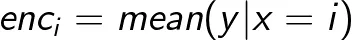

This is reasonable, but there’s a big problem with this approach: some groups may be too small or too variable to be reliable. Many supervised encodings overcome this issue by choosing a middle way between the group mean and the global mean of y:

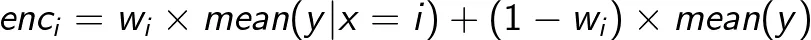

where w_i is between 0 and 1, depending on how “credible” is the group mean.

The next three algorithms (TargetEncoder, MEstimateEncoder and JamesSteinEncoder) differ based on how they define w_i.

In TargetEncoder, the weight depends on the group numerosity and on a parameter called “smoothing”. When smoothing is 0, we rely solely on group means. Then, as smoothing increases, the global mean weights more and more, leading to a stronger regularization.

In [90]:
x = pd.Series([
    '1_High-School', '1_High-School', '2_Bachelors', 
    '2_Bachelors', '2_Bachelors', '2_Bachelors',
    '3_Masters', '3_Masters', '3_Masters', '4_PhD', '4_PhD'
    ], name = 'x')
y = pd.Series([35, 38, 49, 45, 52, 55, 63, 47, 67, 51, 73], name = 'y')

In [91]:
count_encoding = x.replace(x.value_counts().to_dict())
y_grand_mean = y.mean()
y_level_mean = x.replace(y.groupby(x).mean())
smoothing = 1
weight = 1 / (1 + np.exp(-(count_encoding - 1) / smoothing))
target_encoding = y_level_mean * weight + y_grand_mean * (1 - weight)

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/2543398705.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  count_encoding = x.replace(x.value_counts().to_dict())
/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/2543398705.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_level_mean = x.replace(y.groupby(x).mean())


In [92]:
count_encoding = x.replace(y.groupby(x).count())
y_grand_mean = x.apply(lambda l: y.mean())
y_level_mean = x.replace(y.groupby(x).mean())
target_encoding = dict()
for smoothing in [0, 1, 10]:
    weight = 1 / (1 + np.exp(-(count_encoding - 1) / smoothing))
    target_encoding[smoothing] = (y_level_mean * weight + y_grand_mean * (1 - weight)).round(2)

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/2867729176.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  count_encoding = x.replace(y.groupby(x).count())
/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/2867729176.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_level_mean = x.replace(y.groupby(x).mean())


In [93]:
show = pd.concat([x, y, y_level_mean, y_grand_mean] + [target_encoding[i] for i in target_encoding.keys()], axis = 1)
show.columns = [
    ['x', 'y', 'y_level_mean', 'y_grand_mean'] + ['TargetEncoding'] * len(target_encoding), 
    [''] * 4 + ['smoothing={}'.format(sm) for sm in target_encoding.keys()]
]
show.round(2)

x   y y_level_mean y_grand_mean TargetEncoding              \
                                                   smoothing=0 smoothing=1   
0   1_High-School  35        36.50        52.27          36.50       40.74   
1   1_High-School  38        36.50        52.27          36.50       40.74   
2     2_Bachelors  49        50.25        52.27          50.25       50.35   
3     2_Bachelors  45        50.25        52.27          50.25       50.35   
4     2_Bachelors  52        50.25        52.27          50.25       50.35   
5     2_Bachelors  55        50.25        52.27          50.25       50.35   
6       3_Masters  63        59.00        52.27          59.00       58.20   
7       3_Masters  47        59.00        52.27          59.00       58.20   
8       3_Masters  67        59.00        52.27          59.00       58.20   
9           4_PhD  51        62.00        52.27          62.00       59.38   
10          4_PhD  73        62.00        52.27          62.00       59.38   

                 
   smoothing=10  
0         43.99  
1         43.99  
2         51.11  
3         51.11  
4         51.11  
5         51.11  
6         55.97  
7         55.97  
8         55.97  
9         57.38  
10        57.38

## 12. MEstimateEncoder

MEstimateEncoder resembles TargetEncoder, but w_i depends on a parameter called “m”, which sets how much the global mean should weight in absolute terms. m is easy to understand because it can be considered as a number of observations: if the level has exactly m observations, then the level mean and the overall mean weight the same.

In [94]:
x = pd.Series([
    '1_High-School', '1_High-School', '2_Bachelors', 
    '2_Bachelors', '2_Bachelors', '2_Bachelors',
    '3_Masters', '3_Masters', '3_Masters', '4_PhD', '4_PhD'
    ], name = 'x')
y = pd.Series([35, 38, 49, 45, 52, 55, 63, 47, 67, 51, 73], name = 'y')

In [95]:
m = 0
count_encoding = x.replace(y.groupby(x).count())
y_mean = y.mean()
y_level_mean = x.replace(y.groupby(x).mean())
weight = count_encoding / (count_encoding + m)
m_estimate_encoding =  y_level_mean * weight + y_grand_mean * (1 - weight)

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/1631038682.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  count_encoding = x.replace(y.groupby(x).count())
/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/1631038682.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_level_mean = x.replace(y.groupby(x).mean())


In [96]:
m_estimate_encoding = dict()

for m in [0, 1, 10]:
    m_estimate_encoding[m] = ((y_level_mean * count_encoding + y_grand_mean * m) / (count_encoding + m)).round(2)

In [97]:
show = pd.concat([x, y, count_encoding, y_level_mean, y_grand_mean] + [m_estimate_encoding[i] for i in m_estimate_encoding.keys()], axis = 1)
show.columns = [
    ['x', 'y', 'CountEncoding', 'y_level_mean', 'y_grand_mean'] + ['MEstimateEncoding'] * len(m_estimate_encoding), 
    [''] * 5 + ['m={}'.format(m) for m in m_estimate_encoding.keys()]
]
show.round(2)

x   y CountEncoding y_level_mean y_grand_mean  \
                                                                
0   1_High-School  35             2        36.50        52.27   
1   1_High-School  38             2        36.50        52.27   
2     2_Bachelors  49             4        50.25        52.27   
3     2_Bachelors  45             4        50.25        52.27   
4     2_Bachelors  52             4        50.25        52.27   
5     2_Bachelors  55             4        50.25        52.27   
6       3_Masters  63             3        59.00        52.27   
7       3_Masters  47             3        59.00        52.27   
8       3_Masters  67             3        59.00        52.27   
9           4_PhD  51             2        62.00        52.27   
10          4_PhD  73             2        62.00        52.27   

   MEstimateEncoding                
                 m=0    m=1   m=10  
0              36.50  41.76  49.64  
1              36.50  41.76  49.64  
2              50.25  50.65  51.69  
3              50.25  50.65  51.69  
4              50.25  50.65  51.69  
5              50.25  50.65  51.69  
6              59.00  57.32  53.83  
7              59.00  57.32  53.83  
8              59.00  57.32  53.83  
9              62.00  58.76  53.89  
10             62.00  58.76  53.89

## 13. JamesSteinEncoder

TargetEncoder and MEstimateEncoder depend both on the group numerosity and on the value of a parameter (respectively smoothing and m) set by the user. This is not convenient, because setting these weights is a manual task.

A natural question is the following: is there a way to set an optimal w_i, without the need of any human intervention? The JamesSteinEncoder tries to do so in a way that is statistically grounded.

In [98]:
x = pd.Series([
    '1_High-School', '1_High-School', '2_Bachelors', 
    '2_Bachelors', '2_Bachelors', '2_Bachelors',
    '3_Masters', '3_Masters', '3_Masters', '4_PhD', '4_PhD'
    ], name = 'x')
y = pd.Series([35, 38, 49, 45, 52, 55, 63, 47, 67, 51, 73], name = 'y')

In [99]:
y_level_mean = x.replace(y.groupby(x).mean())
y_level_var = x.replace(y.groupby(x).var())
y_var = y.var()
y_mean = y.mean()
weight = 1 - (y_level_var / (y_var + y_level_var) * (len(set(x)) - 3) / (len(set(x)) - 1)).clip(lower=0, upper=1)
james_stein_encoding = y_level_mean * weight + y_mean * (1 - weight)

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/2301997436.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_level_mean = x.replace(y.groupby(x).mean())
/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/2301997436.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_level_var = x.replace(y.groupby(x).var())


The intuition is that the mean of a group with high variance should be trusted less. Therefore, the higher the group variance, the lower the weight.

Let’s see a numeric example:

In [100]:
show = pd.concat([x, y, y_level_mean, y_level_var, pd.Series(y.mean(), index = x.index), pd.Series(y.var(), index = x.index), weight, james_stein_encoding], axis = 1)
show.columns = ['x', 'y', 'y_level_mean', 'y_level_var', 'y_mean', 'y_var', 'weight', 'JamesSteinEncoding']
show.round(2)

,x,y,y_level_mean,y_level_var,y_mean,y_var,weight,JamesSteinEncoding
0,1_High-School,35,36.50,4.50,52.27,136.42,0.99,36.67
1,1_High-School,38,36.50,4.50,52.27,136.42,0.99,36.67
2,2_Bachelors,49,50.25,18.25,52.27,136.42,0.96,50.33
3,2_Bachelors,45,50.25,18.25,52.27,136.42,0.96,50.33
4,2_Bachelors,52,50.25,18.25,52.27,136.42,0.96,50.33
5,2_Bachelors,55,50.25,18.25,52.27,136.42,0.96,50.33
6,3_Masters,63,59.00,112.00,52.27,136.42,0.85,57.99
7,3_Masters,47,59.00,112.00,52.27,136.42,0.85,57.99
8,3_Masters,67,59.00,112.00,52.27,136.42,0.85,57.99
9,4_PhD,51,62.00,242.00,52.27,136.42,0.79,59.93


The JamesSteinEncoder has two significant advantages: it provides better estimates than the maximum-likelihood estimator, and it doesn’t need any parameter setting.

## 14. GLMMEncoder

GLMMEncoder follows a totally different approach. Basically, it fits a Linear Mixed Effect Model on y. This approach exploits the fact that Linear Mixed Effect Models are designed precisely for handling homogeneous groups of observations (as well explained here). Thus, the idea is to fit a model with no regressors (only the intercept) and to use the levels as groups.

Then, the output is simply the sum of the intercept and the random effect of the group.

In [101]:
x = pd.Series([
    '1_High-School', '1_High-School', '2_Bachelors', 
    '2_Bachelors', '2_Bachelors', '2_Bachelors',
    '3_Masters', '3_Masters', '3_Masters', '4_PhD', '4_PhD'
    ], name = 'x')
y = pd.Series([35, 38, 49, 45, 52, 55, 63, 47, 67, 51, 73], name = 'y')

In [102]:
model = smf.mixedlm(formula = 'y ~ 1', data = y.to_frame(), groups = x).fit()
intercept = model.params['Intercept']
random_effect = x.replace({k: float(v) for k, v in model.random_effects.items()})
glmm_encoding = intercept + random_effect

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/4276372295.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  random_effect = x.replace({k: float(v) for k, v in model.random_effects.items()})
/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/4276372295.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  random_effect = x.replace({k: float(v) for k, v in model.random_effects.items()})


In [103]:
show = pd.concat([x, y, pd.Series(intercept, index = x.index), random_effect, glmm_encoding], axis = 1)
show.columns = ['x', 'y', 'intercept', 'random_effect', 'GLMMEncoding']
show.round(2)

,x,y,intercept,random_effect,GLMMEncoding
0,1_High-School,35,52.05,-10.82,41.24
1,1_High-School,38,52.05,-10.82,41.24
2,2_Bachelors,49,52.05,-1.48,50.57
3,2_Bachelors,45,52.05,-1.48,50.57
4,2_Bachelors,52,52.05,-1.48,50.57
5,2_Bachelors,55,52.05,-1.48,50.57
6,3_Masters,63,52.05,5.38,57.43
7,3_Masters,47,52.05,5.38,57.43
8,3_Masters,67,52.05,5.38,57.43
9,4_PhD,51,52.05,6.92,58.97


## 15. WOEEncoder

WOEEncoder (which stands for “Weight of Evidence” Encoder) can be employed only for binary target variables, i.e. target variables whose levels are 0/1.

The idea behind Weight of Evidence is that you have two distributions:

the distribution of 1s (# of 1s in each group / # of 1s in all y)
the distribution of 0s (# of 0s in each group / # of 0s in all y)
The heart of the algorithm is dividing the distribution of 1s by the distribution of 0s (for each group). Of course, the higher this value, the more confident we are that the group is “skewed” towards 1s, and viceversa. Then, the logarithm of this value is taken.

In [104]:
x = pd.Series([
    '1_High-School', '1_High-School', '2_Bachelors', 
    '2_Bachelors', '2_Bachelors', '2_Bachelors',
    '3_Masters', '3_Masters', '3_Masters', '4_PhD', '4_PhD'
    ], name = 'x')
y = pd.Series([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], name = 'y')

In [105]:
y_level_ones = x.replace(y.groupby(x).apply(lambda l: (l == 1).sum()))
y_level_zeros = x.replace(y.groupby(x).apply(lambda l: (l == 0).sum()))
y_ones = (y == 1).sum()
y_zeros = (y == 0).sum()
nominator = y_level_ones / y_ones
denominator = y_level_zeros / y_zeros
woe_encoder = np.log(nominator / denominator)

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/1424376763.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_level_ones = x.replace(y.groupby(x).apply(lambda l: (l == 1).sum()))
/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_51482/1424376763.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_level_zeros = x.replace(y.groupby(x).apply(lambda l: (l == 0).sum()))


In [106]:
show = pd.concat([x, y, y_level_ones, y_level_zeros, pd.Series(y_ones, index = x.index), pd.Series(y_zeros, index = x.index), nominator, denominator, woe_encoder], axis = 1)
show.columns = ['x', 'y', 'y_level_ones', 'y_level_zeros', 'y_ones', 'y_zeros','nominator', 'denominator', 'WOEEncoding']
show

,x,y,y_level_ones,y_level_zeros,y_ones,y_zeros,nominator,denominator,WOEEncoding
0,1_High-School,1,1,1,4,7,0.25,0.142857,0.559616
1,1_High-School,0,1,1,4,7,0.25,0.142857,0.559616
2,2_Bachelors,0,1,3,4,7,0.25,0.428571,-0.538997
3,2_Bachelors,0,1,3,4,7,0.25,0.428571,-0.538997
4,2_Bachelors,1,1,3,4,7,0.25,0.428571,-0.538997
5,2_Bachelors,0,1,3,4,7,0.25,0.428571,-0.538997
6,3_Masters,0,1,2,4,7,0.25,0.285714,-0.133531
7,3_Masters,1,1,2,4,7,0.25,0.285714,-0.133531
8,3_Masters,0,1,2,4,7,0.25,0.285714,-0.133531
9,4_PhD,0,1,1,4,7,0.25,0.142857,0.559616


As you can see, due to the presence of a logarithm in the formula, the output is not not directly interpretable. However, it works pretty well as a preprocessing step for machine learning.

## 16. LeaveOneOutEncoder

All the 15 encoders seen up until now have a unique mapping.

However, if you plan to use the encoding as input for a predictive model (for example a gradient boosting), this could be a problem. In fact, suppose that you use TargetEncoder. This would imply that you are introducing information about y_train inside X_train, which could lead to a serious risk of overfitting.

The point is: how to maintain a supervised encoding, while limiting the risk of overfitting? LeaveOneOutEncoder offers a brilliant solution. It does a vanilla target encoding but, for each row, it does not consider the value of y observed for that row. In this way, it avoids row-wise leakage.

In [107]:
x = pd.Series([
    '1_High-School', '1_High-School', '2_Bachelors', 
    '2_Bachelors', '2_Bachelors', '2_Bachelors',
    '3_Masters', '3_Masters', '3_Masters', '4_PhD', '4_PhD'
    ], name = 'x')
y = pd.Series([35, 38, 49, 45, 52, 55, 63, 47, 67, 51, 73], name = 'y')

In [108]:
y_level_except_self = x.to_frame().apply(lambda row: y[x == row['x']].drop(row.name).to_list(), axis = 1)
leave_one_out_encoding = y_level_except_self.apply(np.mean)

In [109]:
show = pd.concat([x, y, y_level_except_self, leave_one_out_encoding], axis = 1)
show.columns = ['x', 'y', 'y_level_except_self', 'LeaveOneOutEncoding']
show['LeaveOneOutEncoding'] = show['LeaveOneOutEncoding'].round(2)
show

,x,y,y_level_except_self,LeaveOneOutEncoding
0,1_High-School,35,[38],38.00
1,1_High-School,38,[35],35.00
2,2_Bachelors,49,"[45, 52, 55]",50.67
3,2_Bachelors,45,"[49, 52, 55]",52.00
4,2_Bachelors,52,"[49, 45, 55]",49.67
5,2_Bachelors,55,"[49, 45, 52]",48.67
6,3_Masters,63,"[47, 67]",57.00
7,3_Masters,47,"[63, 67]",65.00
8,3_Masters,67,"[63, 47]",55.00
9,4_PhD,51,[73],73.00


## 17. CatBoostEncoder

CatBoost is a gradient boosting algorithm (like XGBoost or LightGBM) that has shown to work extremely well in a wide range of problems. The encoding algorithm is described in detail here (our implementation is a little simplified, but it’s good for grasping the concept).

CatboostEncoder works basically like LeaveOneOutEncoder, but following an on-line approach.

But how to simulate an on-line behaviour in an off-line setting? Imagine that you have a table. Then, take a row somewhere in the middle of the table. What CatBoost does is pretending that the rows above the current row have been observed previously in time, while the rows below have yet to be observed (i.e. will be observed in the future). Then, the algorithm does a leave-one-out encoding, but based only on the rows already observed.

In [110]:
x = pd.Series([
    '1_High-School', '1_High-School', '2_Bachelors', 
    '2_Bachelors', '2_Bachelors', '2_Bachelors',
    '3_Masters', '3_Masters', '3_Masters', '4_PhD', '4_PhD'
    ], name = 'x')
y = pd.Series([35, 38, 49, 45, 52, 55, 63, 47, 67, 51, 73], name = 'y')

In [111]:
a = 1
y_mean = y.mean()
y_level_before_self = x.to_frame().apply(lambda row: y[(x == row['x']) & (y.index < row.name)].to_list(), axis = 1)
catboost_encoding = y_level_before_self.apply(lambda ylbs: (sum(ylbs) + y_mean * a) / (len(ylbs) + a))

In [112]:
show = pd.concat([x, y, pd.Series(y.mean(), index = x.index), y_level_before_self, catboost_encoding], axis = 1)
show.columns = ['x', 'y', 'y_mean', 'y_level_before_self', 'CatBoostEncoding']
show.round(2)


,x,y,y_mean,y_level_before_self,CatBoostEncoding
0,1_High-School,35,52.27,[],52.27
1,1_High-School,38,52.27,[35],43.64
2,2_Bachelors,49,52.27,[],52.27
3,2_Bachelors,45,52.27,[49],50.64
4,2_Bachelors,52,52.27,"[49, 45]",48.76
5,2_Bachelors,55,52.27,"[49, 45, 52]",49.57
6,3_Masters,63,52.27,[],52.27
7,3_Masters,47,52.27,[63],57.64
8,3_Masters,67,52.27,"[63, 47]",54.09
9,4_PhD,51,52.27,[],52.27


This may seem absurd. Why throwing away some information that could be useful? You can see it simply as more extreme attempt of randomizing the output (i.e. reducing overfitting).